# Introduction
***
Notebook **#2-ensemble_modelling_daun_singkong_eksperimen_1** mengimplementasikan sesuai tahapan yang diusulkan dari paper acuan

# Import Libraries

In [20]:
import pandas as pd
import numpy as np

# sklearn for utilization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, fbeta_score
from sklearn.model_selection import StratifiedKFold

# modelling for ensemble method
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# visualization purpose
import matplotlib.pyplot as plt

# utils
import pickle

#
from models.model_ensembles import EnsembleStacking

# Load Data After Preprocessing

In [2]:
dataset_daun_singkong_after_preprocessing = pickle.load(open('../dataset/data_covid_after_preprocessing.pkl', 'rb'))
X_train = dataset_daun_singkong_after_preprocessing['training']['X']
y_train = dataset_daun_singkong_after_preprocessing['training']['y']
X_test = dataset_daun_singkong_after_preprocessing['testing']['X']
y_test = dataset_daun_singkong_after_preprocessing['testing']['y']

In [3]:
# sampling data
# X_train = X_train[:1000]
# X_test = X_test[:1000]
# y_train = y_train[:1000]
# y_test = y_train[:1000]

# Defining Global Variables 

In [4]:
kfold = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)

# global variables for MLP
max_iter=400 
batch_size=32 
verbose=1
n_iter_no_change=20

# Defining Global Functions

In [5]:
def create_new_input_training_features(ensemble_classifiers, X, y):
    all_predicted_results = dict()
    list_of_majority_voting_each_models = list()

    for model_name, models in ensemble_classifiers.items():
        print("\t\t\t", model_name.upper())

        # voting scenario for new data input prepration for ANN model
        if len(models)!=0:
            all_predicted_results[model_name] = dict()
            for sub_model_name, dict_models in models.items():
                all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X)

            # make dataframe for 5 model prediction results on X and get the mode label for that 5 prediction
            model_df_voting = pd.DataFrame(all_predicted_results[model_name]).mode(axis=1)[0]
            model_df_voting.columns = ['majority_vote_from_'+model_name]
            list_of_majority_voting_each_models.append(model_df_voting)
            
    new_input_features = pd.concat(list_of_majority_voting_each_models, axis=1)
    new_input_features['ground_truth'] = y.copy()
            
    return new_input_features

# Modelling

## Create Stacking ML Ensemble from 5-fold cross-validation

In [6]:
ensemble_classifiers = EnsembleStacking(X_train, y_train, X_test, y_test, kfold).train_ensemble()

In [7]:
ensemble_classifiers

{'svm': {'model-1': {'train': SVC(),
   'training': 0.7504006748207508,
   'validation': 0.7422402159244265,
   'testing': 0.7471264367816092},
  'model-2': {'train': SVC(),
   'training': 0.7483762125685365,
   'validation': 0.7412280701754386,
   'testing': 0.7455518815934499},
  'model-3': {'train': SVC(),
   'training': 0.7489666807254323,
   'validation': 0.7473009446693657,
   'testing': 0.7482286254133207},
  'model-4': {'train': SVC(),
   'training': 0.7515816111345424,
   'validation': 0.7284075573549258,
   'testing': 0.7463391591875296},
  'model-5': {'train': SVC(),
   'training': 0.7520242914979757,
   'validation': 0.7188660141748228,
   'testing': 0.7461817036687136}},
 'logreg': {'model-1': {'train': LogisticRegression(solver='newton-cg'),
   'training': 0.639139603542809,
   'validation': 0.6508097165991903,
   'testing': 0.6493465595969139},
  'model-2': {'train': LogisticRegression(solver='newton-cg'),
   'training': 0.6418388865457613,
   'validation': 0.64035087719

## Create new input Training from the stacking ensemble ML

In [8]:
new_input_training_features = create_new_input_training_features(
    ensemble_classifiers, 
    X_train,
    y_train
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [9]:
new_input_training_features

,0,0,0,0,ground_truth
0,2.0,2.0,2.0,1.0,1.0
1,0.0,2.0,2.0,0.0,0.0
2,2.0,2.0,2.0,2.0,2.0
3,1.0,1.0,2.0,2.0,2.0
4,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...
14814,2.0,0.0,2.0,2.0,2.0
14815,2.0,2.0,2.0,1.0,1.0
14816,2.0,2.0,2.0,2.0,2.0
14817,0.0,0.0,2.0,0.0,0.0


## Feed New Input features into ANN

In [10]:
# split X and y from new_input_features before feeding to ANN
new_X_train, new_y_train = new_input_training_features.drop(['ground_truth'],axis=1), new_input_training_features['ground_truth']
# new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=45)

# feed new X and new y into ANN
ann_model = MLPClassifier(max_iter=max_iter, batch_size=batch_size, verbose=verbose, n_iter_no_change=n_iter_no_change)
ann_model.fit(new_X_train, new_y_train)

predicted_ann_train = ann_model.predict(new_X_train)

print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Data = ", accuracy_score(new_y_train, predicted_ann_train))

Iteration 1, loss = 0.45889132
Iteration 2, loss = 0.06730646
Iteration 3, loss = 0.01790423
Iteration 4, loss = 0.00750261
Iteration 5, loss = 0.00367849
Iteration 6, loss = 0.00210628
Iteration 7, loss = 0.00135738
Iteration 8, loss = 0.00094889
Iteration 9, loss = 0.00070964
Iteration 10, loss = 0.00055888
Iteration 11, loss = 0.00046177
Iteration 12, loss = 0.00039700
Iteration 13, loss = 0.00035292
Iteration 14, loss = 0.00032279
Iteration 15, loss = 0.00030191
Iteration 16, loss = 0.00028741
Iteration 17, loss = 0.00027707
Iteration 18, loss = 0.00026964
Iteration 19, loss = 0.00026390
Iteration 20, loss = 0.00025935
Iteration 21, loss = 0.00025534
Iteration 22, loss = 0.00025150
Iteration 23, loss = 0.00024772
Iteration 24, loss = 0.00024386
Iteration 25, loss = 0.00023993
Iteration 26, loss = 0.00023602
Iteration 27, loss = 0.00023208
Iteration 28, loss = 0.00022826
Iteration 29, loss = 0.00022458
Iteration 30, loss = 0.00022103
Iteration 31, loss = 0.00021757
Training loss did

# Save Stacking Model Pretrained (MLs + ANN)

In [11]:
# save trained ensemble stacking classifiers
model_ensemble_experiment_1 = {
    'stacking_ensembles': ensemble_classifiers,
    'ann': ann_model,
    'data': {
        'training': {
            'X': X_train,
            'y': y_train
        },
        'testing': {
            'X': X_test,
            'y': y_test
        }
    }
}
pickle.dump(model_ensemble_experiment_1, open("model_ensemble_experiment_results/model_ensemble_eksperimen_1.pkl", 'wb'))

In [13]:
def create_new_input_features(ensemble_classifiers, X, y):
    all_predicted_results = dict()
    list_of_majority_voting_each_models = list()

    for model_name, models in ensemble_classifiers.items():
        print("\t\t\t", model_name.upper())

        # voting scenario for new data input prepration for ANN model
        if len(models)!=0:
            all_predicted_results[model_name] = dict()
            for sub_model_name, dict_models in models.items():
                all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X)

            # make dataframe for 5 model prediction results on X and get the mode label for that 5 prediction
            model_df_voting = pd.DataFrame(all_predicted_results[model_name]).mode(axis=1)[0]
            model_df_voting.columns = ['majority_vote_from_'+model_name]
            list_of_majority_voting_each_models.append(model_df_voting)
            
    new_input_features = pd.concat(list_of_majority_voting_each_models, axis=1)
    new_input_features['ground_truth'] = y.copy()
            
    return new_input_features

In [14]:
new_input_testing_features_scenario_1_covid = create_new_input_features(
    ensemble_classifiers, 
    X_test,
    y_test
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [16]:
new_input_testing_features_scenario_1_covid

,0,0,0,0,ground_truth
0,1.0,1.0,2.0,1.0,1.0
1,2.0,2.0,2.0,2.0,2.0
2,2.0,2.0,2.0,2.0,2.0
3,0.0,2.0,2.0,0.0,0.0
4,1.0,1.0,2.0,1.0,1.0
...,...,...,...,...,...
6346,0.0,0.0,2.0,0.0,0.0
6347,1.0,2.0,2.0,1.0,2.0
6348,2.0,2.0,2.0,2.0,1.0
6349,2.0,3.0,2.0,2.0,2.0


In [22]:
def print_model_experiment_results(name_of_scenario, y_test, y_pred):
    print('\t\t' + '='*30)
    print('\t\tHASIl UJI COBA {}'.format(name_of_scenario.upper()))
    print('\t\t' + '='*30)
    print("\tAkurasi Score: ", accuracy_score(y_test, y_pred))
    print("\tMacro Recall Score: ", recall_score(y_test, y_pred, average='macro'))
    print("\tMacro Precision Score: ", precision_score(y_test, y_pred, average='macro'))
    print("\tMacro F1-score Score: ", fbeta_score(y_test, y_pred, beta=1, average='macro'))
    print("\tMacro F2-score Score: ", fbeta_score(y_test, y_pred, beta=2, average='macro'))
    print("\tMacro F0.5-score Score: ", fbeta_score(y_test, y_pred, beta=0.5, average='macro'))
    
    print()
    print()
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(14,8))
    disp.plot()
    plt.show()

		HASIl UJI COBA SKENARIO UJI COBA 3
	Akurasi Score:  0.7024090694378838
	Macro Recall Score:  0.6855559527516003
	Macro Precision Score:  0.7043903918949511
	Macro F1-score Score:  0.693397330846411
	Macro F2-score Score:  0.6883508885291854
	Macro F0.5-score Score:  0.6995738626393733


              precision    recall  f1-score   support

         0.0       0.65      0.70      0.67      1086
         1.0       0.62      0.62      0.62      1804
         2.0       0.77      0.76      0.76      3058
         3.0       0.79      0.67      0.72       403

    accuracy                           0.70      6351
   macro avg       0.70      0.69      0.69      6351
weighted avg       0.70      0.70      0.70      6351



<Figure size 1008x576 with 0 Axes>

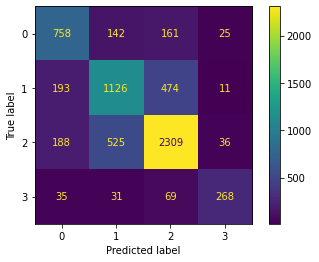

In [23]:
# split X and y from new_input_features before feeding to ANN
new_X_test_scenario_3, new_y_test_scenario_3 = new_input_testing_features_scenario_1_covid.drop(['ground_truth'],axis=1), new_input_testing_features_scenario_1_covid['ground_truth']

# predict new X test using pre-trained ANN before
predicted_ann_testing_scenario_3 = ann_model.predict(new_X_test_scenario_3)

# print testing results
print_model_experiment_results('Skenario Uji Coba 3', new_y_test_scenario_3, predicted_ann_testing_scenario_3)